# MNIST Classifier Model

In [198]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Getting data and viewing path

In [199]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/storage/data/mnist_png/training'),Path('/storage/data/mnist_png/testing')]

In [200]:
(path/"training/1").ls()

(#6742) [Path('/storage/data/mnist_png/training/1/42690.png'),Path('/storage/data/mnist_png/training/1/49817.png'),Path('/storage/data/mnist_png/training/1/12078.png'),Path('/storage/data/mnist_png/training/1/5862.png'),Path('/storage/data/mnist_png/training/1/36368.png'),Path('/storage/data/mnist_png/training/1/57223.png'),Path('/storage/data/mnist_png/training/1/37725.png'),Path('/storage/data/mnist_png/training/1/54103.png'),Path('/storage/data/mnist_png/training/1/29986.png'),Path('/storage/data/mnist_png/training/1/18207.png')...]

## Loading data appropriately

In [201]:
#function used to load data appropriatly
def load_data(folder):
    dataList = []
    labelList = []
    for num in range(10):
        data_path = (path/folder/f'{num}').ls().sorted() #getting path
        
        stackedData = torch.stack([tensor(Image.open(o)) for o in data_path]) #Open each image and stack them
        stackedData = stackedData.float()/255.0 #squishing between 0-1
        
        dataList.append(stackedData) #adding to dataList
        labelList.extend([num]*len(data_path))#extending labelList
    
    #Convert into a single tensor with each image data in each row
    train_x = torch.cat(dataList).view(-1, 28*28) 
    train_y = tensor(labelList)
    
    return train_x, train_y

train_x, train_y = load_data("training")
test_x, test_y = load_data("testing")

### Creating dataloaders (Minibatches)

In [202]:
train_dset = list(zip(train_x,train_y))
valid_dset = list(zip(test_x,test_y))

dl_train = DataLoader(train_dset, batch_size=256)
dl_test = DataLoader(valid_dset, batch_size=256)

### This is what the data looks like

<AxesSubplot:>

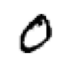

In [256]:
show_image(train_x[0].view(28,28))

## Below is the functions we need to train and test the model

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = F.cross_entropy(preds, yb)
    loss.backward()

def train_epoch(model):
    for xb,yb in dl_train:
        calc_grad(xb, yb, model)
        
        for p in params: 
            p.data -= p.grad.data * lr
            p.grad.zero_()

def batch_accuracy(xb, yb):
    pred = xb.softmax(1) # gets final activations into range of 0,1 so that all add up to 1
    accuracy = get_num_correct(pred, yb)/float(yb.size(0))
    return accuracy

def get_num_correct(preds, yb):
    return preds.argmax(dim=1).eq(yb).sum().float()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in dl_test]
    return round(torch.stack(accs).mean().item(), 4)

def linear_layer(xb):
    return xb@w + b

def init_params(x, var=1.0): 
    return (torch.randn(x)*var).requires_grad_()

## Begin by initializing parameters

In [245]:
lr = 1.
w = init_params((28*28,10))
b = init_params(10)
params = w, b

## Now lets see if our loss improves for 1 epoch

In [257]:
validate_epoch(linear_layer)

0.183

In [258]:
train_epoch(linear_layer)
validate_epoch(linear_layer)

0.289

## It improved, so now lets train the model

In [218]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')
        
train_model(linear_layer, 20)

0.2726 0.308 0.3438 0.3682 0.3947 0.4164 0.4332 0.4462 0.4539 0.4604 0.466 0.4692 0.4732 0.4762 0.4793 0.4825 0.4843 0.4858 0.4879 0.4896 

## We can do all of the above very easily by using FastAI toolkit
### Additionally, I will also add some nonlinearity this time

In [231]:
dls = DataLoaders(dl_train, dl_test)

simple_net = nn.Sequential(
    nn.Linear(28*28,30), #30 neurons
    nn.ReLU(),
    nn.Linear(30, 10) # 30neurons into 10 output neurons (10 classes)
)

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=F.cross_entropy, metrics=accuracy)

learn.fit(20, .01)

epoch,train_loss,valid_loss,accuracy,time
0,1.460385,3.105183,0.100900,00:01
1,0.930706,2.921132,0.101200,00:01
2,0.712777,2.385295,0.188500,00:01
3,0.599163,2.020884,0.324600,00:01
4,0.531909,1.787350,0.385900,00:01
5,0.485915,1.628456,0.423500,00:01
6,0.451067,1.514974,0.450500,00:01
7,0.423412,1.429631,0.472800,00:01
8,0.400912,1.362436,0.490200,00:01
9,0.382621,1.307440,0.505100,00:01


### So it seems that adding nonlinearity increased the accuracy by 10%!